### Relatório trabalho final Ciência de Dados
- Alunos:
    - Draylon Vieira Lopes
    - Thiago Brandenburg
    - Rodrigo Augusto Krauel

- Importando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

- Carregando o dataset

In [23]:
df = pd.read_csv('DailyDelhiClimateTrain.csv')
df_test = pd.read_csv('DailyDelhiClimateTest.csv')
df.info(), df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          1462 non-null   object 
 1   meantemp      1462 non-null   float64
 2   humidity      1462 non-null   float64
 3   wind_speed    1462 non-null   float64
 4   meanpressure  1462 non-null   float64
dtypes: float64(4), object(1)
memory usage: 57.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


(None, None)

- Temos 4 variáveis de entrada: Temperatura, Umidade, Velocidade do vento e pressão

- Definindo as datas como indice

In [24]:
df['date'] = pd.to_datetime(df['date'])#, format='%d.%m.%Y %H:%M:%S')
df = df.set_index('date')

df_test['date'] = pd.to_datetime(df_test['date'])#, format='%d.%m.%Y %H:%M:%S')
df_test = df_test.set_index('date')

- Vamos visualizar as séris temporais utilizando gráficos de linha

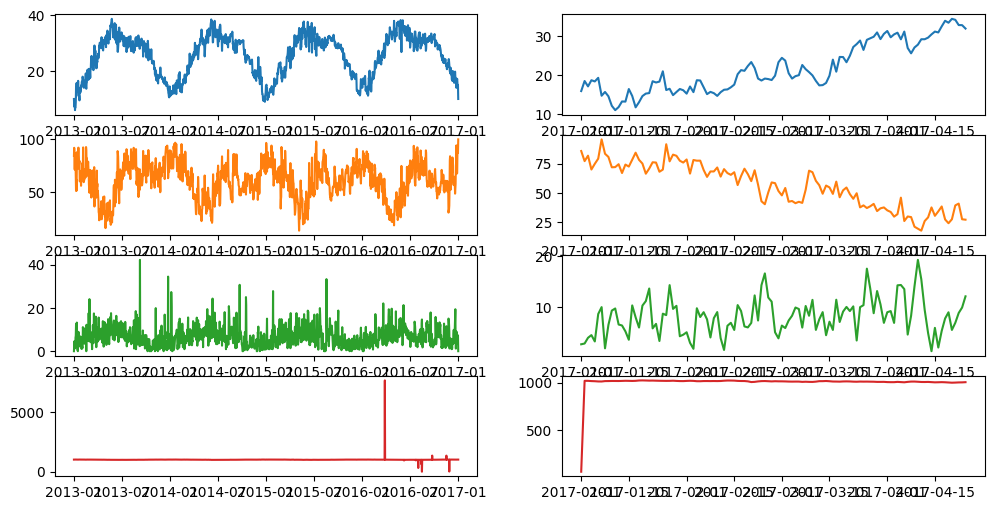

In [25]:
fig, ax = plt.subplots(len(df.columns),2,figsize=(12, 6))

for i,col in enumerate(df.columns):
    ax[i,0].plot(df[col],color=plt.cm.tab10(i))
    ax[i,1].plot(df_test[col],color=plt.cm.tab10(i))


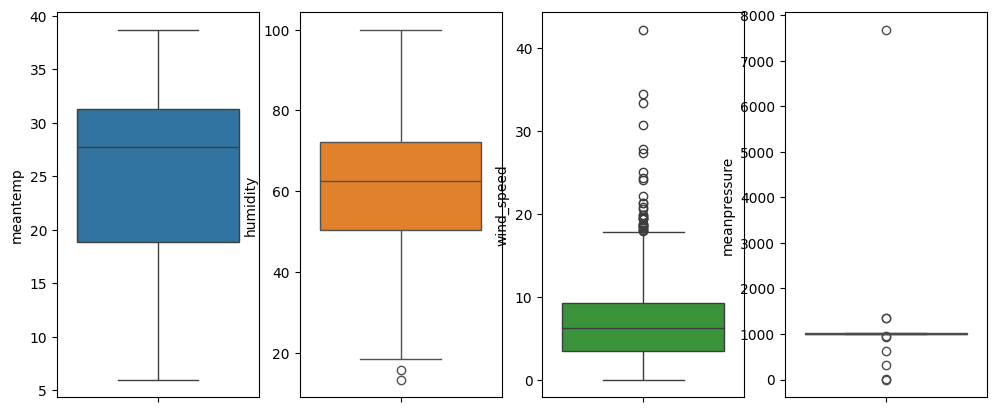

In [27]:
fig, ax = plt.subplots(1,4,figsize=(12,5))
for i,col in enumerate(df.columns):
    sns.boxplot(df[col],ax=ax[i], color=plt.cm.tab10(i))

- Para a temperatura e umidade, não há outliers perceptíveis visualmente
- Para a velocidade do vento, alguns pontos possuem valores elevados, mas não é possível dizer se se outliers ou não, provavelmente representam rajadas de vento
- Já na pressão, é perceptível a presença de outliers, com um outliers superior bem ressaltado.
- Vamos gerar as distribuições utilizando cortes dos limites superiores e inferiores

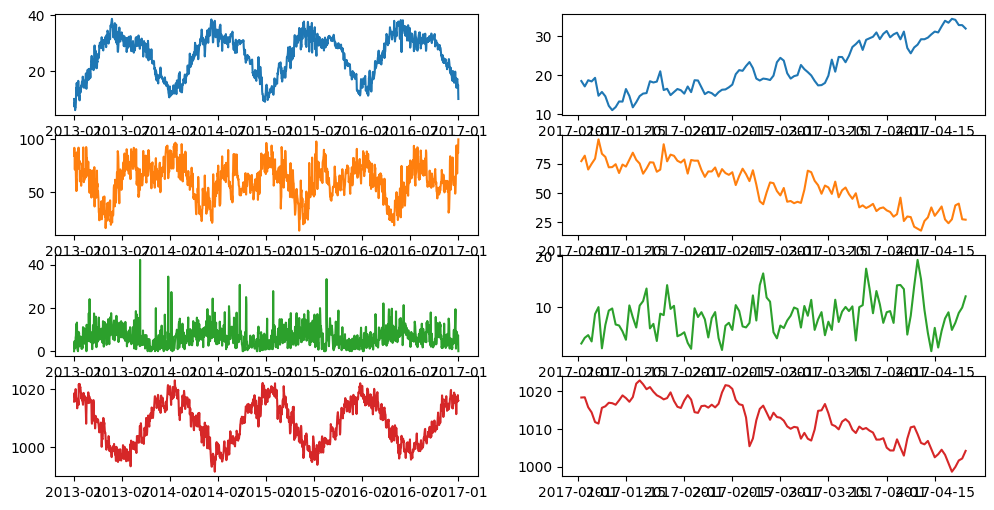

In [28]:
filters = []

for i, iter_df in enumerate([df,df_test]):
    Q1 = iter_df['meanpressure'].quantile(0.25)
    Q3 = iter_df['meanpressure'].quantile(0.75)
    IQR = Q3 - Q1
    filter = (iter_df['meanpressure'] >= Q1 - 1.5 * IQR) & (iter_df['meanpressure'] <= Q3 + 1.5 *IQR)
    filters.append(filter)
    sml1 = iter_df.loc[filter]
    #sml1.plot(subplots=True)

fig, ax = plt.subplots(len(df.columns),2,figsize=(12, 6))

for i,col in enumerate(df.columns):
    ax[i,0].plot(df.loc[filters[0]][col],color=plt.cm.tab10(i))
    ax[i,1].plot(df_test.loc[filters[1]][col],color=plt.cm.tab10(i))

- Com o corte dos outliers, é possível observar um comportamento para a pressão
- Com os dados cortados, podemos gerar a base de treino e teste definitivas

- Função para gerar as séries de predição

In [20]:
def create_features_labels(df, cols, window_size=7):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df[cols].iloc[i:i+window_size].values.flatten())
        y.append(df[cols].iloc[i+window_size].values.flatten())
    return np.array(X), np.array(y)

- Vamos utilizar uma janela de 7 dias para os modelos

In [29]:
windows_size  = 7


X_train, y_train = create_features_labels(df.loc[filters[0]],df.columns, window_size=windows_size)
X_test, y_test = create_features_labels(df_test.loc[filters[1]], df_test.columns, window_size=windows_size)
X_train[0], y_train[0]


(array([  10.        ,   84.5       ,    0.        , 1015.66666667,
           7.4       ,   92.        ,    2.98      , 1017.8       ,
           7.16666667,   87.        ,    4.63333333, 1018.66666667,
           8.66666667,   71.33333333,    1.23333333, 1017.16666667,
           6.        ,   86.83333333,    3.7       , 1016.5       ,
           7.        ,   82.8       ,    1.48      , 1018.        ,
           7.        ,   78.6       ,    6.3       , 1020.        ]),
 array([   8.85714286,   63.71428571,    7.14285714, 1018.71428571]))

In [34]:
print(f'X_train {X_train.shape}, y_train {y_train.shape}, X_test {X_test.shape}, y_test {y_test.shape}')

X_train (1446, 28), y_train (1446, 4), X_test (106, 28), y_test (106, 4)


- Temos 1446 entradas de treinamento e 106 entradas de teste. Como váriaveis de entrada temos 28 valores (4 váriaveis * 7 dias) e como saída temos as 4 váriaveis

**Modelos**

- Neste relatório, só será abordado os resultados de cada modelo, os treinamentos de cada modelo estão respectivamente nos arquivos impl1.ipynb (Random Forest), impl2 (SARIMAX+AG) e impl3.ipynb (Rede Neural Artificial (ANN)).

In [40]:
resultados = {
    'modelo':['Random Forest', 'SARIMAX+AG', 'ANN'],
    'Temperatura':[0.873, 0.795, 0.902], 
    'Umidade':[0.828, 0.685, 0.855],
    'Vento':[-0.008, 0.060, 0.095],
    'Pressão':[0.844, 0.600, 0.898],
    'Total':[0.634, 0.535, 0.687],
}
resultados = pd.DataFrame(resultados)
resultados.index = resultados['modelo']
resultados.drop('modelo',axis=1,inplace=True)
resultados

,Temperatura,Umidade,Vento,Pressão,Total
modelo,,,,,
Random Forest,0.873,0.828,-0.008,0.844,0.634
SARIMAX+AG,0.795,0.685,0.060,0.600,0.535
ANN,0.902,0.855,0.095,0.898,0.687


<Axes: ylabel='modelo'>

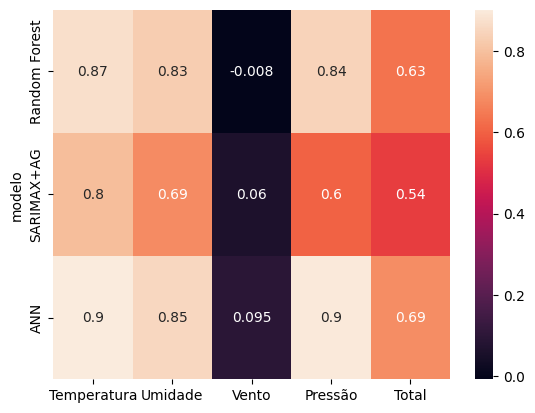

In [41]:
sns.heatmap(resultados, annot=True)

- O modelo ANN apresentou os melhores resultados, seguido muito próximo pelo Random Forest
- O SARIMAX+AG não apresentou resultados tão relevantes
- No geral, foi possível obter modelos precisos para a temperatura, umidade e pressão.
- O vento se apresentou praticamente aleatório